# NETSI Special Topic: Causal Analysis
## Jupyter notebook on instrumental variable approach (IV)

In [3]:
## Set seed and parameters
library(lfe) # for OLS (easier robust SE)
library(AER) # for IV
set.seed(10)
N <- 50000

Loading required package: Matrix
Loading required package: car
Loading required package: carData
Loading required package: lmtest
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘lmtest’

The following object is masked from ‘package:lfe’:

    waldtest

Loading required package: sandwich
Loading required package: survival


In [3]:
set.seed(10)
N <- 50000

### Naive OLS
Causal link from private to salary is confounded by the household wealth, as in the last notebook.

In [4]:
## Create empty dataframe
df <- data.frame("ID" = 1:N)

## Simulate location (we'll assume private schools are only in urban area)
df$urban <- floor(runif(N, min=0, max=2))

## Simulate household wealth
### Let's assume that what matters is HH wealth is > 1M or not (specific amount does not matter)
df$hhw <- floor(runif(N, min=0, max=2))

## Simulate the kid's decision to attend private college 
### Instead of completely random, more likely to attend private college if from wealthy HH
### Living in urban area can sometimes turn decision toward attending private (but not vice versa)
### Let's follow potential outcomes approach and simulate both private0 (D0) and private1 (D1)
df$private0 <- 0.7*df$hhw + runif(N, min=0, max=1) # private school decision by non-urban (private if >1)
df$private1 <- df$private0 + 0.2 # private school decision by urban (private if >1)
df$private0 <- 1*(df$private0>1) # Replace with binary numbers
df$private1 <- 1*(df$private1>1)

### Check monotonicity
print(table(df$private1>=df$private0))

## Determine private1 vs private0 based on urban status
df$private <- df$urban * df$private1 + (1-df$urban) * df$private0

## Simulate earning
treatment.effect <- 10000
df$salary0 <- 50000 + df$hhw*10000 + rnorm(N, mean=0, sd=40000) ## potential outcome, when attending public (Y0)
df$salary1 <- df$salary0 + treatment.effect ## potential outcome, when attending private (Y1)
df$salary <- df$private * df$salary1 + (1-df$private) * df$salary0

## Some sample data
head(df)

## Regression result
OLS <- felm(salary ~ private, data=df)
print(summary(OLS, robust=TRUE))


 TRUE 
50000 


ID,urban,hhw,private0,private1,private,salary0,salary1,salary
1,1,0,0,1,1,54717.43,64717.43,64717.43
2,0,1,1,1,1,141185.69,151185.69,151185.69
3,0,1,1,1,1,57274.26,67274.26,67274.26
4,1,0,0,0,0,22573.59,32573.59,22573.59
5,0,1,1,1,1,54664.85,64664.85,64664.85
6,0,1,1,1,1,51817.56,61817.56,61817.56



Call:
   felm(formula = salary ~ private, data = df) 

Residuals:
    Min      1Q  Median      3Q     Max 
-167244  -27112       9   27124  165052 

Coefficients:
            Estimate Robust s.e t value Pr(>|t|)    
(Intercept)  51737.9      240.2  215.40   <2e-16 ***
private      17144.1      361.5   47.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 40140 on 49998 degrees of freedom
Multiple R-squared(full model): 0.04312   Adjusted R-squared: 0.0431 
Multiple R-squared(proj model): 0.04312   Adjusted R-squared: 0.0431 
F-statistic(full model, *iid*): 2253 on 1 and 49998 DF, p-value: < 2.2e-16 
F-statistic(proj model):  2249 on 1 and 49998 DF, p-value: < 2.2e-16 




### Instrumental variable approach

As you can see above, we get biased result when we run this Naive regression. Suppose we don't observe household wealth, so including household wealth in our regression is impossible. What can we do?

Fortunately, we have an instrument: urban affects wage only through private (exclusion), being urban can only make you to attend private college (monotonicity), and being in urban is not correlated with private school potential outcomes and wage potential outcomes (exogeneity).

Using this, we can run IV and get unbiased estimate for the causal effect of interest.

In [5]:
IV = ivreg(salary ~ private | urban , data = df)
print(summary(IV, robust=TRUE))


Call:
ivreg(formula = salary ~ private | urban, data = df)

Residuals:
       Min         1Q     Median         3Q        Max 
-170859.19  -27217.07      27.89   27159.31  169552.14 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  55352.6      846.4  65.394  < 2e-16 ***
private       9029.3     1856.6   4.863 1.16e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 40340 on 49998 degrees of freedom
Multiple R-Squared: 0.03346,	Adjusted R-squared: 0.03344 
Wald test: 23.65 on 1 and 49998 DF,  p-value: 1.158e-06 



In [6]:
## Check the result from ivreg is equivalent to FS/RF
FS <- felm(private ~ urban, data = df)
RF <- felm(salary ~ urban, data = df)
FS.coef <- coef(summary(FS))["urban",1]
RF.coef <- coef(summary(RF))["urban",1]
print(RF.coef/FS.coef)

[1] 9029.257


### Causal relationship of the previous simulation represented by DAG

In [7]:
library(igraph) # Some igraph tutorial: https://kateto.net/netscix2016.html


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



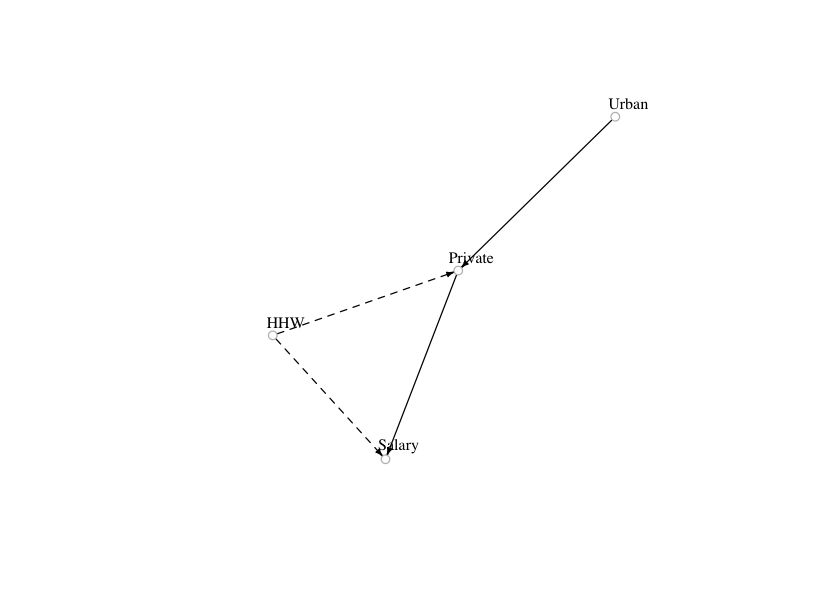

In [8]:
g1 <- graph_from_literal(Urban--+Private,Private--+Salary,HHW--+Private,HHW--+Salary)
E(g1)$lty <- c(1,1,2,2)
options(repr.plot.height=5)
plot(g1, edge.arrow.size=0.5, edge.color="black", vertex.color="white", vertex.size=5, 
     vertex.frame.color="grey", vertex.label.color="black", 
     vertex.label.cex=0.8, vertex.label.dist=1.5, edge.curved=0)

### LATE
To demonstrate that the treatment effect that we're identifying is treatment effect of compliers, let's give much bigger treatment effect to always-takers and never-takers this time.

In [9]:
df.late <- df
te.compliers <- 10000
te.others <- 30000 # 10 times bigger treatment effect

## potential outcome, when attending public (Y0)
df.late$salary0 <- 50000 + df.late$hhw*10000 + rnorm(N, mean=0, sd=40000)

## potential outcome, when attending private (Y1)
df.late$salary1 <- df.late$salary0 + 
                    te.compliers*(df.late$private1>df.late$private0) +
                    te.others*(df.late$private1==df.late$private0)
df.late$salary <- df.late$private * df.late$salary1 + (1-df.late$private) * df.late$salary0

## IV
IV = ivreg(salary ~ private | urban , data = df.late)
print(summary(IV, robust=TRUE))

### Check that the result ~= treatment effect that we gave to the compliers


Call:
ivreg(formula = salary ~ private | urban, data = df.late)

Residuals:
      Min        1Q    Median        3Q       Max 
-162834.6  -28396.3     115.8   28326.7  195514.5 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  60394.0      878.3   68.76  < 2e-16 ***
private      13254.5     1926.4    6.88 6.04e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 41860 on 49998 degrees of freedom
Multiple R-Squared: 0.08986,	Adjusted R-squared: 0.08984 
Wald test: 47.34 on 1 and 49998 DF,  p-value: 6.036e-12 



### Violations of IV assumptions
Now let's take a look at one of the cases where IV assumptions are violated. One example of IV assumption violation is when there is direct effect of being in urban area on our outcome variable (salary). Let's first draw DAG representing this situation, and then simulate it.

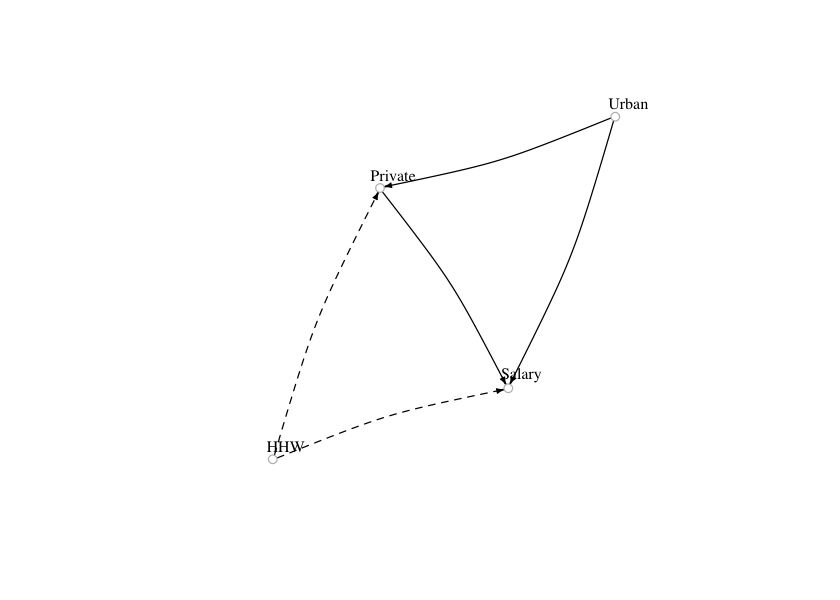

In [10]:
g1 <- graph_from_literal(Urban--+Private,Private--+Salary,HHW--+Private,HHW--+Salary,Urban--+Salary)
E(g1)$lty <- c(1,1,1,2,2)
options(repr.plot.height=5)
plot(g1, edge.arrow.size=0.5, edge.color="black", vertex.color="white", vertex.size=5, 
     vertex.frame.color="grey", vertex.label.color="black", 
     vertex.label.cex=0.8, vertex.label.dist=1.5, edge.curved=0.1)

In [11]:
df.v <- df

## Simulate earning
treatment.effect <- 10000
df.v$salary0 <- 50000 + df.v$hhw*10000 + 10000*df.v$urban + rnorm(N, mean=0, sd=40000) ## potential outcome, when attending public (Y0)
df.v$salary1 <- df.v$salary0 + treatment.effect ## potential outcome, when attending private (Y1)
df.v$salary <- df.v$private * df.v$salary1 + (1-df.v$private) * df.v$salary0

## IV
IV = ivreg(salary ~ private | urban , data = df.v)
print(summary(IV, robust=TRUE))

### As you can see, this can introduce pretty serious problem...


Call:
ivreg(formula = salary ~ private | urban, data = df.v)

Residuals:
      Min        1Q    Median        3Q       Max 
-176731.8  -30989.4     173.2   31381.8  185080.4 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  37730.9      954.3   39.54   <2e-16 ***
private      60372.5     2093.0   28.84   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 45480 on 49998 degrees of freedom
Multiple R-Squared: -0.1923,	Adjusted R-squared: -0.1923 
Wald test:   832 on 1 and 49998 DF,  p-value: < 2.2e-16 



### Exercise
Show a simulation exercise where another IV assumption is violated.

We've already shown the importance of the exclusion assumption above, so we'll break the independence assumption. That is, the instrument is no longer "as good as randomly assigned." It's not hard to imagine that household wealth and urbanity are linked; cost of living is generally higher in urban areas.



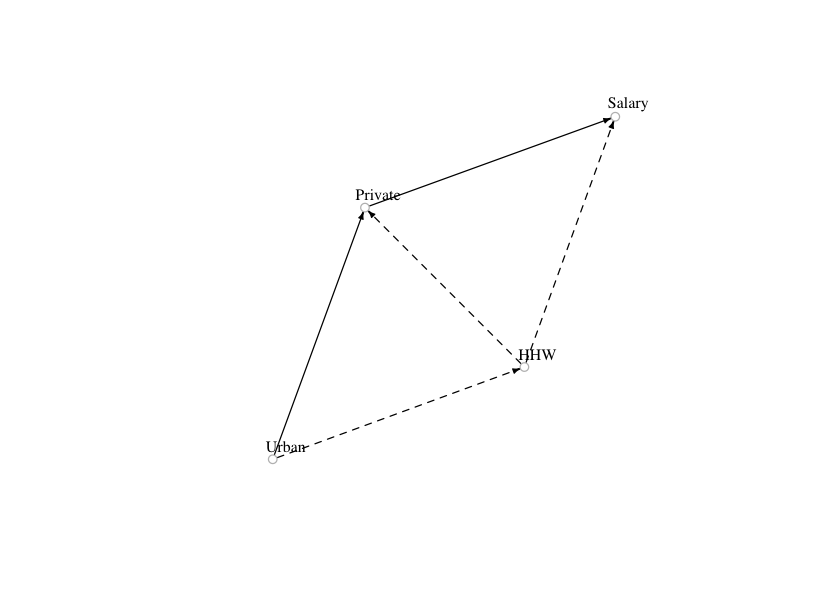

In [12]:
g1 <- graph_from_literal(Urban--+Private,Private--+Salary,HHW--+Private,HHW--+Salary, Urban--+HHW)
E(g1)$lty <- c(1,2,1,2,2)
options(repr.plot.height=5)
plot(g1, edge.arrow.size=0.5, edge.color="black", vertex.color="white", vertex.size=5, 
     vertex.frame.color="grey", vertex.label.color="black", 
     vertex.label.cex=0.8, vertex.label.dist=1.5, edge.curved=0)

In [4]:
#we modify Donghee's code here:
set.seed(10)
N <- 50000
## Create empty dataframe
df <- data.frame("ID" = 1:N)

##we  randomly assign hh wealth
df$hhw <- floor(runif(N, min=0, max=2))

##urbanity is now affected by hhw status
#we'll use the same potential outcomes framework:
df$urban0 <- 0.7*df$hhw + runif(N, min=0, max=1) 
df$urban1 <- df$urban0 + 0.2
df$urban0 <- 1*(df$urban0>1) 

df$urban1 <- 1*(df$urban1>1)
### Check monotonicity
print(table(df$urban1>=df$urban0))

df$urban <- df$hhw * df$urban1 + (1-df$hhw) * df$urban0

print(cor(df$urban, df$hhw))

## Now we do the same as before:
df$private0 <- 0.7*df$hhw + runif(N, min=0, max=1) # private school decision by non-urban (private if >1)
df$private1 <- df$private0 + 0.2 # private school decision by urban (private if >1)
df$private0 <- 1*(df$private0>1) # Replace with binary numbers
df$private1 <- 1*(df$private1>1)

### Check monotonicity
print(table(df$private1>=df$private0))

## Determine private1 vs private0 based on urban status
df$private <- df$urban * df$private1 + (1-df$urban) * df$private0

## Simulate earning
treatment.effect <- 10000
df$salary0 <- 50000 + df$hhw*10000 + rnorm(N, mean=0, sd=40000) ## potential outcome, when attending public (Y0)
df$salary1 <- df$salary0 + treatment.effect ## potential outcome, when attending private (Y1)
df$salary <- df$private * df$salary1 + (1-df$private) * df$salary0

## Some sample data
head(df)

## Regression result
OLS <- felm(salary ~ private, data=df)
print(summary(OLS, robust=TRUE))


 TRUE 
50000 
[1] 0.9046486

 TRUE 
50000 


ID,hhw,urban0,urban1,urban,private0,private1,private,salary0,salary1,salary
1,1,1,1,1,1,1,1,64717.43,74717.43,74717.43
2,0,0,1,0,0,0,0,131185.69,141185.69,131185.69
3,0,0,1,0,0,1,0,47274.26,57274.26,47274.26
4,1,0,0,0,0,0,0,32573.59,42573.59,32573.59
5,0,0,1,0,0,0,0,44664.85,54664.85,44664.85
6,0,0,0,0,0,0,0,41817.56,51817.56,41817.56



Call:
   felm(formula = salary ~ private, data = df) 

Residuals:
    Min      1Q  Median      3Q     Max 
-165473  -26963      24   27009  162899 

Coefficients:
            Estimate Robust s.e t value Pr(>|t|)    
(Intercept)  51034.5      238.3  214.19   <2e-16 ***
private      18932.1      361.4   52.39   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 40060 on 49998 degrees of freedom
Multiple R-squared(full model): 0.05212   Adjusted R-squared: 0.0521 
Multiple R-squared(proj model): 0.05212   Adjusted R-squared: 0.0521 
F-statistic(full model, *iid*): 2749 on 1 and 49998 DF, p-value: < 2.2e-16 
F-statistic(proj model):  2745 on 1 and 49998 DF, p-value: < 2.2e-16 




like before, this naive regression overestimates the impact of private school. IV doesn't help though:

In [5]:
#IV approach:
IV = ivreg(salary ~ private | urban , data = df)
print(summary(IV, robust=TRUE))


Call:
ivreg(formula = salary ~ private | urban, data = df)

Residuals:
       Min         1Q     Median         3Q        Max 
-166430.52  -26977.13     -43.04   27007.59  163644.45 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  50289.5      260.1  193.38   <2e-16 ***
private      20634.4      430.7   47.91   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 40060 on 49998 degrees of freedom
Multiple R-Squared: 0.05169,	Adjusted R-squared: 0.05168 
Wald test:  2296 on 1 and 49998 DF,  p-value: < 2.2e-16 



What's going on here? The IV estimate is overestimating the impact of private school because urbanity is not a perfect instrument.  urbanity is correlated with hhw and hhw is corrrelated with private school, so using urbanity as an instrument is going to overemphasize the amount of high hhw people who chose to private school. This biases the IV estimate of private school on salary even more upwards than the OLS estimate.